## Statistical Modeling - Seguimiento

En este notebook, que sirve como conclusión de la Lección 2, se estudian una serie de métodos para evaluar la relación que existe entre el gol y diferentes métricas que pueden funcionar como estimadores del número de goles de un equipo, y por tanto de su rendimiento. Nos centraremos en el análisis de los pases peligrosos a lo largo de la Euro 2020, con datos de Statsbomb. Mediremos cómo la acumulación de pases (peligrosos o no) acerca o aleja a un equipo al gol, a través de regresión lineal y regresión de Poisson.

**Preparación de Datos**

Importaremos los datos de todos los partidos de la Euro2020 y crearemos dos dfs diferentes: uno que guarde la información línea a línea de todos los pases peligrosos que ha habido en el torneo. En el segundo, guardaremos el nº de pases, pases peligrosos, tiros, goles y ID de cada equipo.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mplsoccer import Sbopen, Pitch
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib import colors
import seaborn as sns

parser = Sbopen()
df_comps = parser.competition()
df_match = parser.match(competition_id = 55, season_id = 43)
teams = df_match["home_team_name"].unique()
match_ids = list(df_match["match_id"])
len(match_ids)

51

In [2]:
df_events = pd.DataFrame()
danger_passes_df = pd.DataFrame()

for i in match_ids:
    df = parser.event(i)[0]
    home_team = df_match[df_match['match_id'] == i]['home_team_name'].values[0]
    away_team = df_match[df_match['match_id'] == i]['away_team_name'].values[0]
    
    for team in [home_team,away_team]:
        shots = 0
        passes = 0
        danger_passes = 0
        goals = 0
        rival = df[df['team_name']!=team]['team_name'].unique()[0]
        
        for period in [1,2]:
            pass_df = df[(df['team_name']==team) & (df['type_name']=='Pass') & (df['outcome_name'].isnull()) & (df.period == period) & (df.sub_type_name.isnull())]
            shots_df = df[(df.team_name == team) & (df.type_name == "Shot") & (df.period == period)]
            goals_df = df[(df.team_name == team) & (df.type_name == "Shot") & (df.period == period) & (df.outcome_name=='Goal')]
            shot_times = shots_df.minute*60 + shots_df.second
            shot_window = 15
            
            play_start = shot_times - shot_window
            play_start = play_start.apply(lambda x: x if x>0 else (period-1)*45)
            
            pass_times = pass_df.minute*60 + pass_df.second
            passes_to_shot = pass_times.apply(lambda x: True in ((play_start < x) & (x<shot_times)).unique())
            
            danger_passes_period = pass_df[passes_to_shot]
            
            danger_passes_df = pd.concat([danger_passes_df,danger_passes_period])
            
            passes+=len(pass_df)
            shots+=len(shots_df)
            danger_passes += len(danger_passes_period)
            goals += len(goals_df)
            
        match_info_df = pd.DataFrame({
                    "Team": [team],
                    "Passes": [passes],
                    "Shots": [shots],
                    "Goals": [goals],
                    "Danger Passes": [danger_passes],
                    "Rival":[rival]
                    })
        
        df_events = pd.concat([df_events, match_info_df])

In [3]:
df_events.shape[0]

102

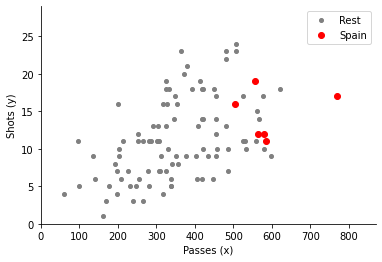

In [4]:
fig,ax = plt.subplots()

ax.plot('Passes','Shots', data=df_events, linestyle='none', markersize=4, marker='o', color='grey', label = 'Rest')
spain_df  = df_events.loc[df_events["Team"] == "Spain"]
ax.plot('Passes','Shots', data=spain_df, linestyle='none', markersize=6, marker='o', color='red', label='Spain')
ax.set_xlim([0,df_events.Passes.max()+100])
ax.set_ylim([0,df_events.Shots.max()+5])
ax.set_xlabel('Passes (x)')
ax.set_ylabel('Shots (y)')
sns.despine()
ax.legend()
plt.show()

#### Model Fitting - Linear Regression

In [5]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102 entries, 0 to 0
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Team           102 non-null    object
 1   Passes         102 non-null    int64 
 2   Shots          102 non-null    int64 
 3   Goals          102 non-null    int64 
 4   Danger Passes  102 non-null    int64 
 5   Rival          102 non-null    object
dtypes: int64(4), object(2)
memory usage: 5.6+ KB


                            OLS Regression Results                            
Dep. Variable:                  Shots   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     30.91
Date:                Sat, 24 Sep 2022   Prob (F-statistic):           2.26e-07
Time:                        15:32:18   Log-Likelihood:                -300.93
No. Observations:                 102   AIC:                             605.9
Df Residuals:                     100   BIC:                             611.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.4793      1.337      3.351      0.0

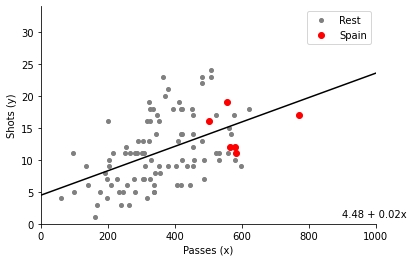

In [6]:
model = smf.ols(formula = 'Shots ~ Passes', data = df_events[['Passes','Shots']]).fit()
print(model.summary())
b = model.params
x = np.arange(0, 1000, step=0.5)
y = b[0] + b[1]*x

fig,ax = plt.subplots()

ax.plot('Passes','Shots', data=df_events, linestyle='none', markersize=4, marker='o', color='grey', label = 'Rest')
spain_df  = df_events.loc[df_events["Team"] == "Spain"]
ax.plot('Passes','Shots', data=spain_df, linestyle='none', markersize=6, marker='o', color='red', label='Spain')
ax.plot(x, y, linestyle='-', color='black')
reg = '{:.2f} + {:.2f}x'.format(b[0],b[1])
plt.annotate(reg,(x.max()-100,1))
print(reg)
ax.set_xlim([0,1000])
ax.set_ylim([0,df_events.Shots.max()+10])
ax.set_xlabel('Passes (x)')
ax.set_ylabel('Shots (y)')
sns.despine()
ax.legend()
plt.show()

#### Model Fitting - Poisson Regression

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Goals   No. Observations:                  102
Model:                            GLM   Df Residuals:                      100
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -144.66
Date:                Sat, 24 Sep 2022   Deviance:                       120.96
Time:                        15:32:19   Pearson chi2:                     99.5
No. Iterations:                     5   Pseudo R-squ. (CS):            0.02174
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1757      0.268     -0.655      0.5

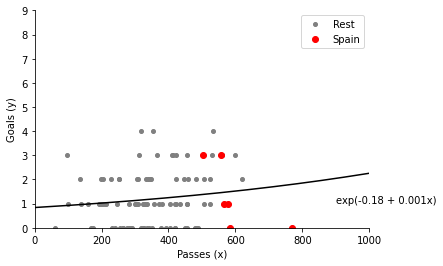

In [7]:
model = smf.glm(formula = 'Goals ~ Passes', data = df_events[['Passes','Goals']],family=sm.families.Poisson()).fit()
print(model.summary())
b = model.params
x = np.arange(0, 1000, step=0.5)
y = np.exp(b[0] + b[1]*x)

fig,ax = plt.subplots()

ax.plot('Passes','Goals', data=df_events, linestyle='none', markersize=4, marker='o', color='grey', label = 'Rest')
spain_df  = df_events.loc[df_events["Team"] == "Spain"]
ax.plot('Passes','Goals', data=spain_df, linestyle='none', markersize=6, marker='o', color='red', label='Spain')
ax.plot(x, y, linestyle='-', color='black')
reg = 'exp({:.2f} + {:.3f}x)'.format(b[0],b[1])
plt.annotate(reg,(x.max()-100,1))
print(reg)
ax.set_xlim([0,1000])
ax.set_ylim([0,df_events.Goals.max()+5])
ax.set_xlabel('Passes (x)')
ax.set_ylabel('Goals (y)')
sns.despine()
ax.legend()
plt.show()

#### Comparing heatmaps - Danger Passes

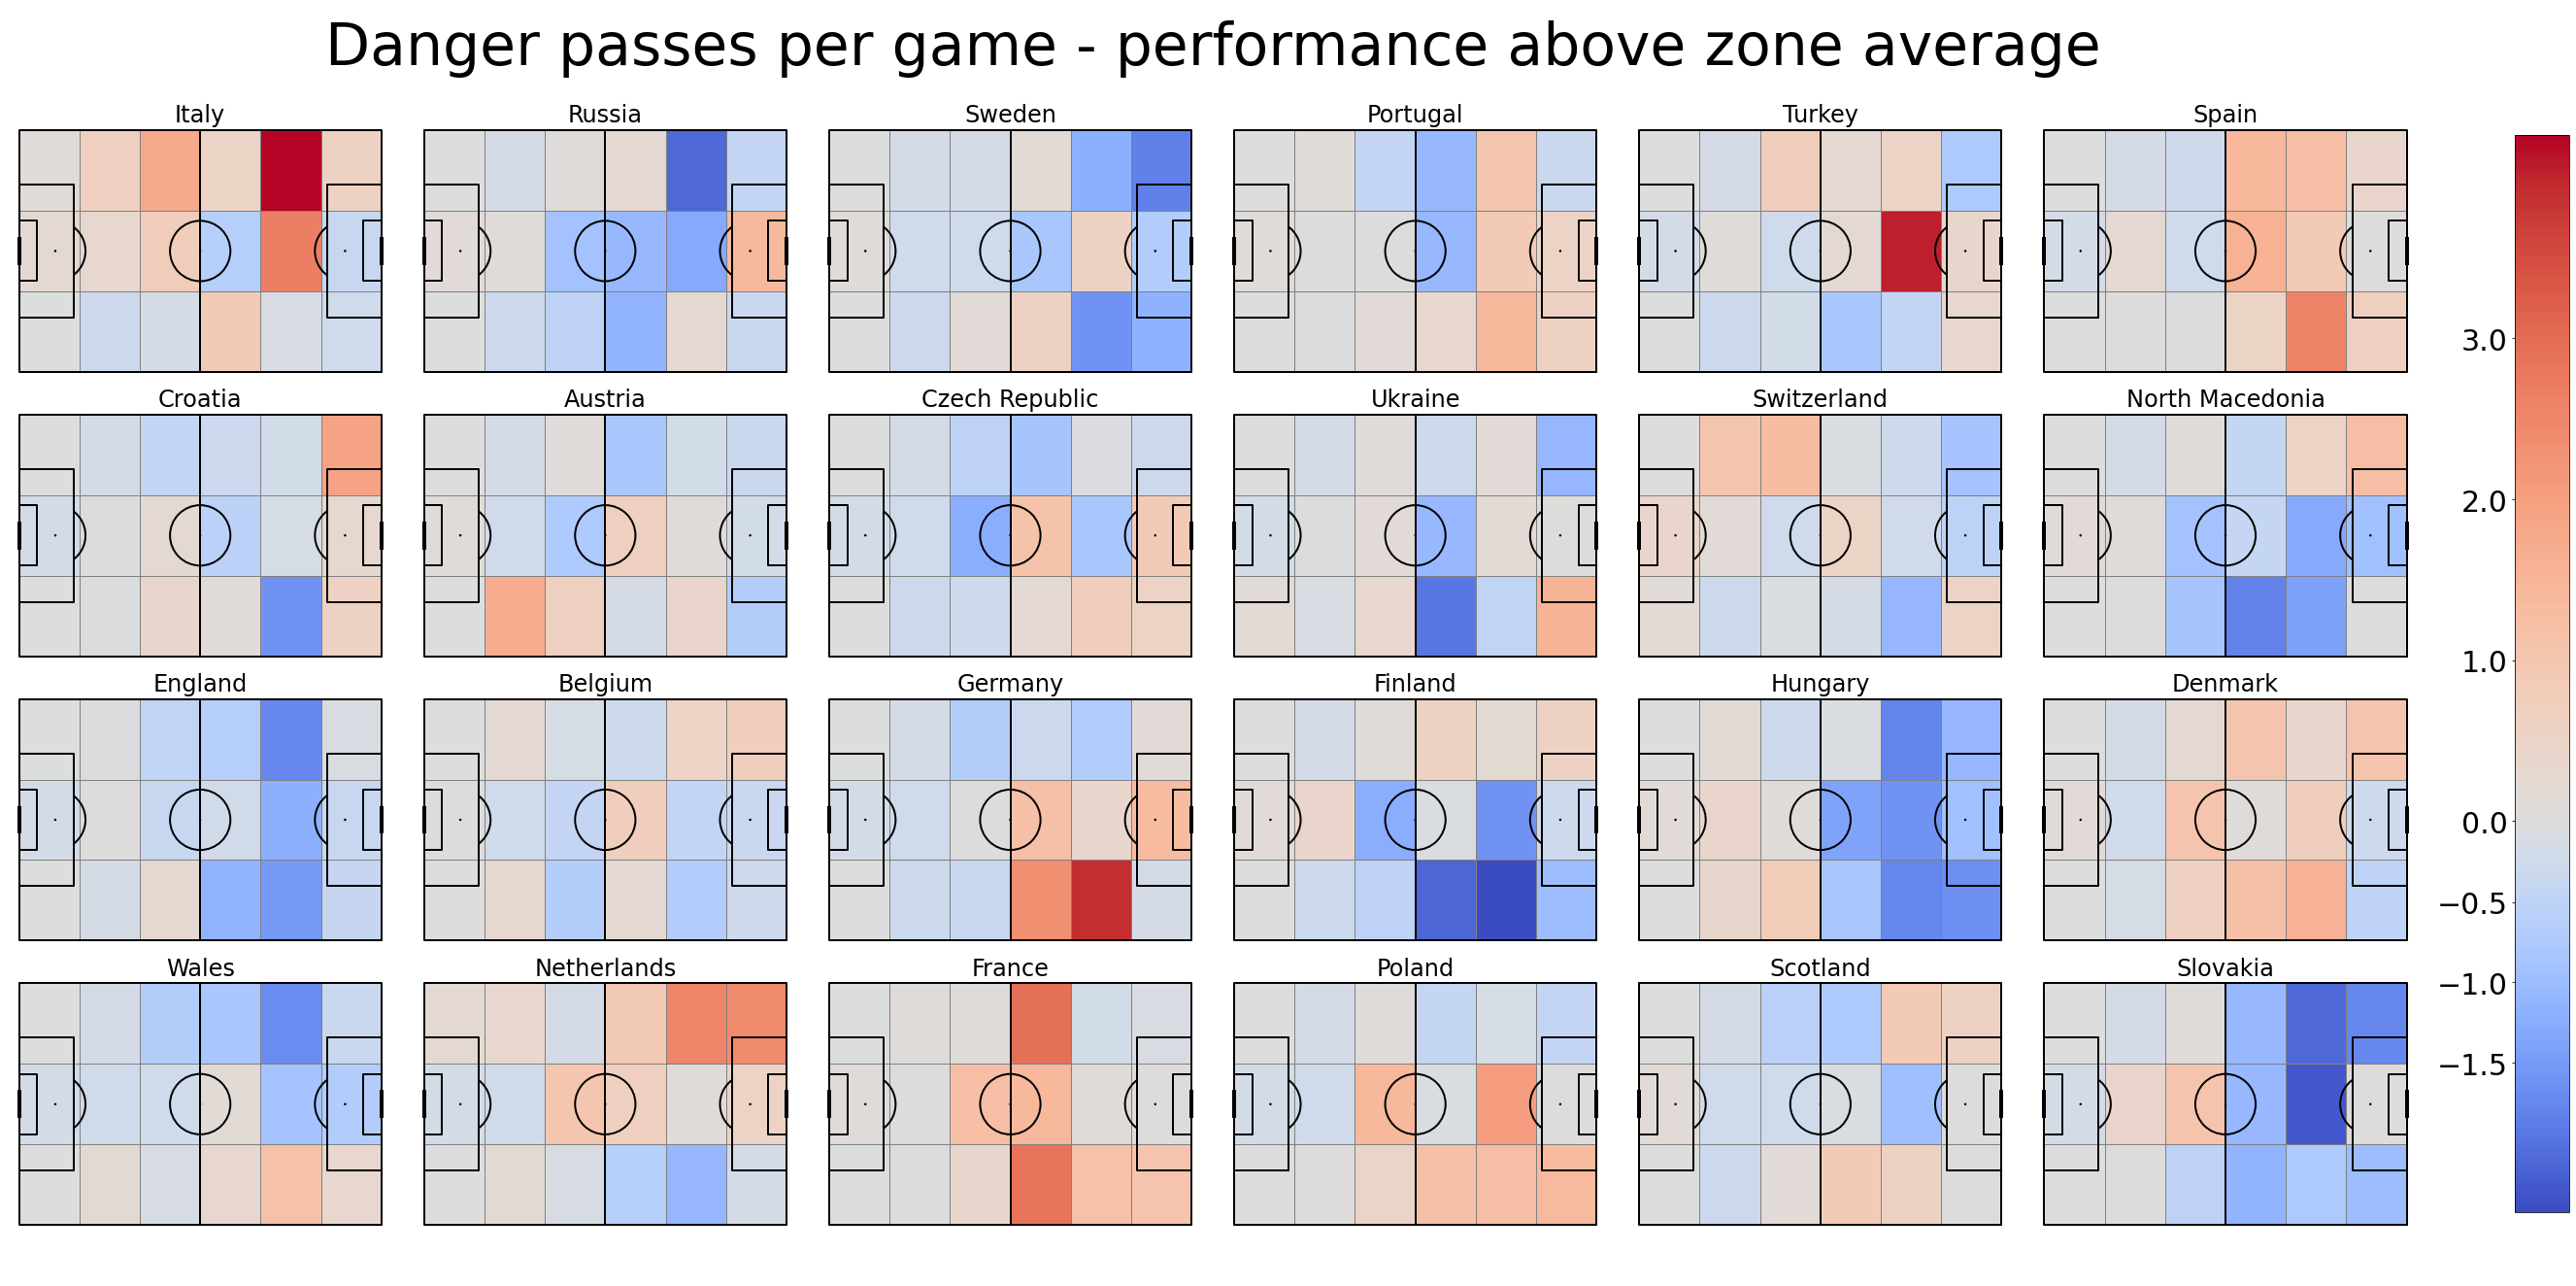

In [8]:
#plot pitch
pitch = Pitch(line_zorder=2, line_color='black')
fig, axs = pitch.grid(ncols = 6, nrows = 4, figheight=20,
                      grid_width=0.88, left=0.025,
                      endnote_height=0.03, endnote_space=0,
                      axis=False,
                      title_space=0.02, title_height=0.06, grid_height=0.8)

#for each team store  bins in a dictionary
hist_dict = {}
for team in teams:
    #get number of games by team
    no_games = len(df_match.loc[(df_match["home_team_name"] == team) | (df_match["away_team_name"] == team)])
    #get danger passes only by this team
    team_danger_passes = danger_passes_df.loc[danger_passes_df["team_name"] == team]
    #number of danger passes in each zone
    bin_statistic = pitch.bin_statistic(team_danger_passes.x, team_danger_passes.y, statistic='count', bins=(6, 3), normalize=False)
    #normalize by number of games
    bin_statistic["statistic"] = bin_statistic["statistic"]/no_games
    #store in dictionary
    hist_dict[team] = bin_statistic

team_pass = pd.DataFrame()
for t in teams:
    grid= pd.DataFrame(sum(hist_dict[t]['statistic'][:,4]) + sum(hist_dict[t]['statistic'][:,5]),columns=[t],index=['Num_Passes_Last3rd']).T
    team_pass = pd.concat([team_pass,grid])
#calculating average per game per zone
avg_hist = np.mean(np.array([v["statistic"] for k,v in hist_dict.items()]), axis=0)

#subtracting average
for team in teams:
    hist_dict[team]["statistic"] = hist_dict[team]["statistic"] - avg_hist

#preparing colormap
vmax = max([np.amax(v["statistic"]) for k,v in hist_dict.items()])
vmin = min([np.amin(v["statistic"]) for k,v in hist_dict.items()])
divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
#for each player
for team, ax in zip(teams, axs['pitch'].flat):
    #put team name over the plot
    ax.text(60, -5, team,
            ha='center', va='center', fontsize=24)
    #plot colormap
    pcm  = pitch.heatmap(hist_dict[team], ax=ax, cmap='coolwarm', norm = divnorm, edgecolor='grey')

#make legend
ax_cbar = fig.add_axes((0.94, 0.093, 0.02, 0.77))
cbar = plt.colorbar(pcm, cax=ax_cbar, ticks=[-1.5, -1, -0.5, 0, 1, 2, 3])
cbar.ax.tick_params(labelsize=30)
ax_cbar.yaxis.set_ticks_position('left')
#add title
axs['title'].text(0.5, 0.5, 'Danger passes per game - performance above zone average', ha='center', va='center', fontsize=60)
plt.show()

In [9]:
gr = df_events.groupby('Team')['Goals'].mean()
gr = pd.merge(gr,team_pass,how='left',left_index=True,right_index=True)
gr

,Goals,Num_Passes_Last3rd
Team,,
Austria,1.000000,13.000000
Belgium,1.600000,13.400000
Croatia,1.500000,14.750000
Czech Republic,1.200000,14.800000
Denmark,2.000000,16.833333
England,1.285714,8.571429
Finland,0.333333,9.333333
France,1.500000,16.000000
Germany,1.000000,18.750000


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Goals   No. Observations:                   24
Model:                            GLM   Df Residuals:                       22
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -26.720
Date:                Sat, 24 Sep 2022   Deviance:                       5.0296
Time:                        15:32:21   Pearson chi2:                     4.48
No. Iterations:                     4   Pseudo R-squ. (CS):            0.03537
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.4866      0

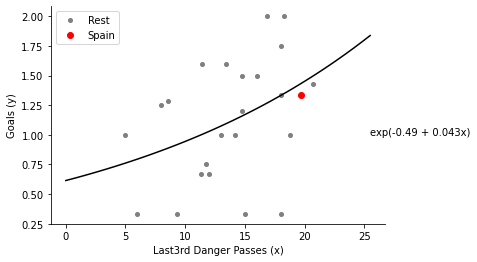

In [10]:
# Poisson Regression

model = smf.glm(formula = 'Goals ~ Num_Passes_Last3rd', data = gr[['Num_Passes_Last3rd','Goals']],family=sm.families.Poisson()).fit()
print(model.summary())
b = model.params
x = np.arange(0, gr['Num_Passes_Last3rd'].max()+5, step=0.5)
y = np.exp(b[0] + b[1]*x)

fig,ax = plt.subplots()

ax.plot('Num_Passes_Last3rd','Goals', data=gr, linestyle='none', markersize=4, marker='o', color='grey', label = 'Rest')
ax.plot('Num_Passes_Last3rd','Goals', data=gr[gr.index=='Spain'], linestyle='none', markersize=6, marker='o', color='red', label='Spain')
ax.plot(x, y, linestyle='-', color='black')
reg = 'exp({:.2f} + {:.3f}x)'.format(b[0],b[1])
plt.annotate(reg,(x.max(),1))
print(reg)


ax.set_xlabel('Last3rd Danger Passes (x)')
ax.set_ylabel('Goals (y)')
sns.despine()
ax.legend()
plt.show()

In [16]:
gr[['Num_Passes_Last3rd','Goals']].corr()

,Num_Passes_Last3rd,Goals
Num_Passes_Last3rd,1.000000,0.398641
Goals,0.398641,1.000000


                            OLS Regression Results                            
Dep. Variable:                  Goals   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     4.157
Date:                Sat, 24 Sep 2022   Prob (F-statistic):             0.0537
Time:                        15:32:21   Log-Likelihood:                -15.360
No. Observations:                  24   AIC:                             34.72
Df Residuals:                      22   BIC:                             37.08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.4845      0

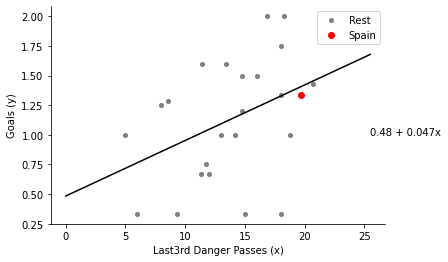

In [11]:
# Linear Regression

model = smf.ols(formula = 'Goals ~ Num_Passes_Last3rd', data = gr[['Num_Passes_Last3rd','Goals']]).fit()
print(model.summary())
b = model.params
x = np.arange(0, gr['Num_Passes_Last3rd'].max()+5, step=0.5)
y = b[0] + b[1]*x

fig,ax = plt.subplots()

ax.plot('Num_Passes_Last3rd','Goals', data=gr, linestyle='none', markersize=4, marker='o', color='grey', label = 'Rest')
ax.plot('Num_Passes_Last3rd','Goals', data=gr[gr.index=='Spain'], linestyle='none', markersize=6, marker='o', color='red', label='Spain')
ax.plot(x, y, linestyle='-', color='black')
reg = '{:.2f} + {:.3f}x'.format(b[0],b[1])
plt.annotate(reg,(x.max(),1))
print(reg)


ax.set_xlabel('Last3rd Danger Passes (x)')
ax.set_ylabel('Goals (y)')
sns.despine()
ax.legend()
plt.show()